# Makine Öğrenmesiyle Tablet Fiyatlandırma, Keşifçi Veri Analizi ve Veri Ön İşleme

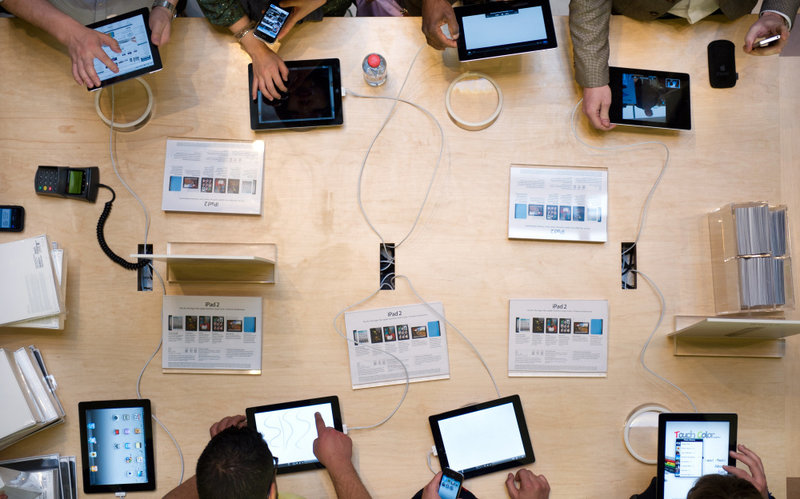

## İçindekiler

* [Kütüphane ve Veri Seti kernel'e dahil etme](#0)
* [Keşifçi Veri Analizi](#1)
    * [Özniteliklerin Korelasyon İlşikileri](#2)
    * [Hedef Değişkenin Dağılı](#3)
    * [Grafik ile Veriyi Yorumlama](#4)
* [Veri Ön İşleme](#5)
    * [Eksik veya Hatalı Değerlerin Tespiti ve İşlemleri](#6)
    * [Dummy Variable Oluşturma](#7)
* [Naive Bayes Algoritması](#8)
    * [Modelin Doğruluk Oranı](#9)
    * [Feature Selection Uygulayarak Modeli Geliştirme](#10)
* [Decision Tree Algoritması](#11)
    * [criterion = entropy Olarak Güncelleme](#12)
* [K Nearest Neighbor (K En Yakın Komşu) Algoritması](#13)
    * [En iyi K değerinin bulunması](#14)

öncelikle projemde kullanacağım ***kütüphanelerimi*** ve ***veri çerçevemizi*** projemize çekirdeğe dahil edelim <a id='0'></a>

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import missingno  
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, precision_score
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from warnings import filterwarnings
from sklearn import ensemble
from sklearn.metrics import confusion_matrix as cm

filterwarnings('ignore')

from matplotlib.legend_handler import HandlerLine2D

In [ ]:
df = pd.read_csv("../input/tabletpc-priceclassification/tablet.csv")

# Keşifçi Veri Analizi (Exploratory Data Analysis) <a id='1'></a>

Evet şimdi de data frame'imizi biraz incelemeye başlayalım. Ne tür öz nitelikler barındırıyor bunların nasıl değerler barındırdığına yada datamızda eksik olan veri olup olmadığını inceleyelim.  

In [ ]:
df.head() #ilk beş gözlemi getirerek inceleyelim

In [ ]:
df.shape #2000 gözlem ve 20 adet öznitelikten oluşan bir datamız var

Herhangi bir özniteliğin eksik olup olmadığını inceleyelim

In [ ]:
df.isna().sum()

***not:*** ön kameranın mp değerini veren öznitelikte 5, RAM özniteliğinde de 12 tane boş değer olduğunu görüyoruz 2000 gözlem olduğunu düşünürsek bu küçük bir orana karşılık geliyor bu yüzden o gözlemleri yada özniteliği silmemizi gerektiren bir durum yok ileride dolduracağız.
Peki bu 20 adet özniteliğin tipi nedir ve bellek kullaımı nedir bunu inceleyelim

In [ ]:
df.info()

Burada bazı değerlerin tipinin object olduğunu görüyoruz var/yok renk gibi... bu değerleri makine öğrenmesinde sayısal değerlere dönüştürmemiz gerektiğini unutmayalım. 
Şimdi sayısal değerlere sahip olan özniteliklerimizin ortalama standart sapma gibi değerlerini görüntüleyelim

In [ ]:
df.describe().T

***not:*** Şimdi bu verilerimizi sayısal değerlerini inceleyelim ilk incelerken gözüme ön kamera mp değerinin, arka kameranın mp değerinin ve çözünürlük yükseklik değerinin minimum 0 olduğu çarpıyor bir kameranın mp değeri veya çözünürlük 0 olabilir mi? elbetteki olamaz belli ki kamera olmama durumu 0 ile ifade edilmiş olabilir yada ekran bilgisi girilmemiş olabilir bu durum da 0 yazılmış olabilir bunu öğrenmek için unique değerlerini inceleyelim ve sonra diğer değerlerimizi incelemeye devam edelim.

In [ ]:
df["OnKameraMP"].unique()

In [ ]:
df[(df["OnKameraMP"] == 0)]

***not:*** Ön kamera ile başlayalım 5 adet değerini olmadığını biliyoruz 471 gözlem de 0 değerini almış yani 471 tane tabletin ön kamerası bulunmuyor olabilir. Bunu ileride modelimizi eğitirken farklı şekillerde kullanabiliriz mesela 0 için kamera yok deriz ve kamera olup olmamasının doğru tahmin etmede ne kadar başarılı olduğunu yada 0 mp alıp mp değerlerinin ne kadar doğru sonuç verdiğini inceleriz.

In [ ]:
df["ArkaKameraMP"].unique()

In [ ]:
df[(df["ArkaKameraMP"] == 0)]

***not:*** Keza burada da 101 adet tabletin arka kamerası 0 mp olarak görüyoruz

In [ ]:
df["CozunurlukYükseklik"].nunique() #1137 adet benzersiz değer var bunları yazdırıpta incelemek çok zor olacaktır.

In [ ]:
df[(df["CozunurlukYükseklik"] == 0)]

***not:*** bu iki gözlem de birbirinden farklı gözlemler belki bunlara da bir değer atayabiliriz yada silebiliriz.

Bir diğer çıkarımım bu tablodan şu oldu Kalinlik özelliği 0.1 ile 1.0 arasında değerler almış yani ölçeklendirme yapılarak tabloya yerleştirilmiş olabilir yani cm cinsinden yapılsa 0.1 cm kalınlık mümkün müdür. 
Başka bir konuya değinecek olursam da tüm değerler incelenndiğinde standart sapmanın yüksek olduğunu fark ediyoruz. Şimdi de bu bu söylediklerimizi görselleştirelim.

Mesela ne inceleyebiliriz fiyat değişkeni sınıf bazında ele alınmış yani sayısal bir değeri yok ama yükseklik bazında çözünürlüğün iki tane boş değeri vardı daha doğrusu 0 girilmiş ön işlemede ona nasıl bir değer atayacağımızı kestirmek için genişlik bazından çözünürlükle arasındaki bağlantıyı görelim.

In [ ]:
fig = plt.gcf()
fig.set_size_inches(11, 7)
sns.scatterplot(x = "CozunurlukYükseklik", y = "CozunurlukGenislik",hue='FiyatAraligi', data = df);

***not:*** yükseklik çözünürlüğünün 500den sonra genişlik çözünürlüğününde minimum aldığı değer artıyor bunu görüyoruz. Ben burada grafiği daha iyi görelim diye biraz büyüttüm ve fiyat kategorisine göre renklendirdim. Bu sayede şunu da görmüş olduk çözünürlük olarak fiyat fiyat düzenli bir ayrım söz konusu değil pahalı dan en ucuza kadar olan tüm kategoriler nerdeyse homojen olarak dağılmışlar fakat özellikle sağ üst köşeye dikkat edersek bu noktada çok ucuz kategorisinden ürün olmadığını görüyoruz. Şunu da eklemek isterim ki özellikle fiyat kategorilerine göre bir yığılma olmaması ve nerdeyse homojen şekilde dağılması bizim ileride yapacağımız sınıflandırmalarda bizim için ayırt edici olma özelliğini düşürüyor.

Yapacağımız bir diğer ilişkilendirme de sayısal değerlerimizin birbiri ile olan ***korelasyon*** ilişkisidir <a id='2'></a>

In [ ]:
df.corr() 

tabi burada 12x12 lik bir tablodan ilişkileri incelemek çok zor olur o yüzden bunu da görselleştirerek daha kolay analiz edilir hale getirelim.

In [ ]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

***not:*** Tablomuzun tamamı nerdeyse siyah renkte yani öznitelikler arasında ilişki yok denecek kadar az Arka kamera mp değeri ile Ön kamera mp değeri arasında ise güzel bir ilişki olduğunu görüyoruz belki girilmemiş olan 5 ön kamera verisini buradan bir çıkarım yaparak bulabiliriz. Keza çözünürlükler arasında zayıf olsa da bir ilişki olduğunu görüyoruz zaten yukarıda bu ilişkiyi görmüştük.

In [ ]:
df.corr()["ArkaKameraMP"]["OnKameraMP"]

***not:*** Bu şekilde en yüksek korelasyon ilişkisi en yüksek olan iki özniteliğimiz arasındaki korelasyon oranı 0.645 şeklinde buluyoruz ama bu bile orta düzey bir ilişkidir. Yani kısaca özniteliklerimizin arasında iyi bir ilişki olduğunu söyleyemeyiz.

Peki bir de özniteliklerimizi kendi içinde değerlendirelim. Öncelikle makine öğrenmesinde bulmayı ***hedeflediğim özniteliğin dağılımı*** inceleyeceğim. <a id='3'></a>

In [ ]:
df['FiyatAraligi'].value_counts()

In [ ]:
sns.countplot(x = "FiyatAraligi", data = df);

***not:*** Çok güzel hepsinden eşit sayıda gözlem var yani dengeli bir yapı var bu bizim istediğimiz bir şeydi. Böyle olmasaydı mecbur veriyi daha dengeli bir hale getimemiz gerekecekti (mesela hastalık seneryosunda popülasyonun 10.000 de 1'i hastalıklı ise bunun üzerin de çalışırken işlemler yapmalıydık) ama buna gerek duymayacağız.

Diğer özellikleri de başka grafikler kullanarak inceleyebiliriz. <a id='4'></a>

In [ ]:
sns.distplot(df["ArkaKameraMP"], bins=16, color="purple");

***not:*** 0 ila 20 arasında değer alan arka kamera mp değerinin dengeli bir şekilde dağıldığını görebiliyoruz. özellikle herhangi bir aralıkta bir yoğunluk gözlemlenmedik

In [ ]:
sns.distplot(df["MikroislemciHizi"], bins=16, color="gold");

***not:*** İşlemcinin hızı ile ilgili 0.5 ile 3.0 GHz frekansları arasında değer aldığını görüyoruz 0.5'te bir yoğunluk olması dışında diğer değerlerde dengeli dağılmıştır. Buradan tüm fiyat segmentinde tablet sayısının eşit olduğunu bildiğimiz için farklı fiyat segmentinde tabletlerin aynı işlemci hızına sahip olduğunu anlayabiliriz. 

In [ ]:
sns.distplot(df["OnKameraMP"], bins=16, color="blue");

***not:*** 0'a yakın değerlerin daha yoğun olduğunu grafikten çıkarabiliyoruz. zaten 471 tane 0 değer aldığını biliyorduk.

bu şekilde tüm hepsini yapmayacağım ama Mesela diğer özniteliklerin değerleri ile fiyat arasında bir ilişki var mı merak ediyorum onu da violinplot kullanarak inceleyelim. İlk önce RAM miktarı ile arasındaki ilişkiyi görelim.

In [ ]:
sns.violinplot(x = "FiyatAraligi", y = "RAM", data = df);

***not:*** Güzel çünkü bu mantığa yatkın olan bir sonuç pahalı olan cihazda daha fazla RAM miktarı olacaktır

Birkaç tane daha gözlem yapalım.

In [ ]:
sns.violinplot(x = "FiyatAraligi", y = "BataryaGucu", data = df); 

In [ ]:
sns.violinplot(x = "FiyatAraligi", y = "DahiliBellek", data = df); 

In [ ]:
sns.violinplot(x = "FiyatAraligi", y = "MikroislemciHizi", data = df);

***not:*** Genel olarak baktığımızda ilişklerde anormal sayılacak bir durum yok. Ama şunu da not etmek gerekir ki RAM hariç diğer özniteliklerimizde farklı fiyat kategorilerindeki tabletlerin benzer grafiklere sahip olduğunu görmekteyiz bu bize sınıflandırma yaparken bu özelliklerin aslında çok da belirleyici bir özelliği olmadığınını gösterir. Çünkü zaten her kategoride aynı sonuçları vermiştir ama özellikle RAM özniteliğinde kategorilere göre RAM miktarlarının yoğunluğunun değiştiğini görüyoruz bu özniteliğin sınıflandırma yaparken bizim için daha değerli bir özellik olacağını öngörebiliriz.

Evet sürekli sayısal veriler üzerinde düşünmek doğru olamaz tabiki kullandığı teknolojiler de fiyat aralığını belirleyen en temel unsurlardandır. Öyleyse biraz da o öznitelikleri inceleyelim.

In [ ]:
df.axes # hangi öznitelikler vardı

In [ ]:
sns.countplot(df["Bluetooth"]);

In [ ]:
sns.countplot(df["Dokunmatik"]);

In [ ]:
sns.countplot(df["4G"]);

***not:*** bu verilerinde önceden baktığımız FiyatAraligina benzer şekilde dengeli dağıldığını görmekteyiz.

In [ ]:
sns.factorplot("FiyatAraligi", "CozunurlukYükseklik","WiFi", data = df, kind = "bar");

# Veri Ön İşleme <a id='5'></a>

Öncelikle veri ön işleme nedir? sorusuna cevap vereyim toplanan verilerin tutarsız olanlarını eleyerek bu ekleyerek, silerek yada değiştirerek olabilir makine'ye öğretmeden daha uygun hale getirmektir kısaca. Öncelikle öz niteliklerimiz nelerdi bunların hedef olarak gördüğümüz FiyatAraligi özniteliğini ne kadar etkiliyorlar bu gibi sorulara cevap verelim. Öyleyse tekrardan özniteliklerimize bakalım.


In [ ]:
df.columns

In [ ]:
sns.countplot(df["FiyatAraligi"]); #önceden bunu incelemiştik zaten dengeli bir şekilde olması bizim avantaj

#### Eksik veya Hatalı Değerlerin Tespiti ve İşlemleri   <a id='6'></a>

In [ ]:
df.isna().sum()

isna fonksiyonu ile kaç tane eksik veri olduğunu gördük bunu tablo olarakta görüntüleyelim.

In [ ]:
missingno.matrix(df,figsize=(20, 10));

In [ ]:
missingno.heatmap(df, figsize= (15,8));

***not:*** bu ısı haritası ile boş değerler arasında nasıl bir ilişki olduğuna dair bir fikir edinebiliriz burada 0'a yakın bir ilişki gözlemledik zaten keşifçi veri analizinde öznitelikler arasında kuvvetli ilişki olmadığını görmüştük.

Şimdi bir fonksiyon ile boş olan değerler yüzde olarak hamgi değerde olduğunu inceleyelim yüzde olarak büyük bir eksiği varsa ve modelimiz için fazla kullanışlı olmadığını düşünüyorsak onu silelim.

In [ ]:
def eksik_deger_tablosu(df): 
    eksik_deger = df.isnull().sum()
    eksik_deger_yuzde = 100 * df.isnull().sum()/len(df)
    eksik_deger_tablo = pd.concat([eksik_deger, eksik_deger_yuzde], axis=1)
    eksik_deger_tablo_son = eksik_deger_tablo.rename(columns = {0 : 'Eksik Değerler', 1 : '% Değeri'})
    return eksik_deger_tablo_son

In [ ]:
eksik_deger_tablosu(df)

Yüzdelik olarak değerleri çok küçük yani onları gözden çıkarmak akıl işi olmaz burada. Bu yüzden onları doldurmayı deneyeceğiz.

In [ ]:
df[(df["BataryaOmru"] < 0)]

In [ ]:
df["WiFi"].unique()

In [ ]:
df[(df["CozunurlukYükseklik"] == 0)]

***not:*** Tüm boş ifadeler nan olarak gözükmüyor olabilir belki bir şey girilmedi diye "-1" girilmiş olabilirdi veya diğer özelliklere "girilmedi" şeklinde bulunabilirdi. Aynı şekilde bazı durumlar mantıklı değildir mesela çözünürlük değerinin 0 olması yada ekranlar arasında bir standart vardır. 50:1 oranında bir tablet ekranı olmaz bu gibi mantık hatası bulunan gözlemleri inceleyelim. Ben burada tüm öznitelikleri bu şekilde inceledim sadece "CozunurlukYükseklik" 0 değerini aldığı için onu göstermek istedim.

Öncelikle boş olan değerlerimizin diğer öznitelikler özellikle de FiyatAraligi ile nasıl bir ilişkisi olduğunu inceleyelim ve boş değeri buna göre dolduralım. 

In [ ]:
sns.countplot(df[df["OnKameraMP"].isnull()]["FiyatAraligi"]);

In [ ]:
df.groupby("FiyatAraligi")[["OnKameraMP"]].mean()

***not:*** Ön kamera özelliğinin tüm boş değerleri çok ucuz kategorisinde rastladık buradan nasıl bir çıkarım yapabiliriz tabi 5 tane gözlem çıkarımızı kesin doğru olduğunu göstermez ama burada çok ucuz tablet kategorisinde belki 0 MP gibi değere sahip olma durumu gibi  olmuş olabilir belki de bu yüzden bir değer girilmemiştir. Tabi bu çıkarımın kesinliğinden emin değiliz bu sebeple o gözlemlerdem de yararlanmak için çok ucuz kategorisine giren tabletlerin ortalaması ile dolduracağız. 

In [ ]:
sns.countplot(df[df["RAM"].isnull()]["FiyatAraligi"]);

In [ ]:
df.groupby("FiyatAraligi")[["RAM"]].mean()

***not:*** burada da tüm değerlerimiz Pahalı fiyat aralığına gelen tabletlerin değerlerine denk geldi. ortalamayı bozmadan bu boş değerleri de doldurabiliriz.

In [ ]:
df[(df["FiyatAraligi"] == "Çok Ucuz") & (df["OnKameraMP"].isnull())]

In [ ]:
df[(df["FiyatAraligi"] == "Pahalı") & (df["RAM"].isnull())]

Hem OnKameraMP hem de RAM özniteliklerimizin hangi gözlemlerde null olduklarını bu şekilde gösterdik şimdi bunların indislerini bir değişkene atayalım.

In [ ]:
CokUcuz_OnKameraMP = df[(df["FiyatAraligi"] == "Çok Ucuz") & (df["OnKameraMP"].isnull())].index

In [ ]:
Pahalı_RAM = df[(df["FiyatAraligi"] == "Pahalı") & (df["RAM"].isnull())].index

Şimdi sıra geldi boş değerleri kendi bulduğumuz değerler ile doldurmaya burada ".loc" fonksiyonunu kullanacağım bu fonksiyon girilen kordinatları belirlenen değerler ile doldurmamızı sağlıyor. Biz de indexlerimizi ve öznitelikleri girerek o null değerleri dolfuruyoruz.

In [ ]:
df.loc[CokUcuz_OnKameraMP ,"OnKameraMP"] = 4.1
df.loc[Pahalı_RAM, "RAM"] = 3449
#burada çok küçük bir yuvarlama işlemi yaptım 4.09 -> 4.1 ve RAM miktarındaki kesirli kısım bunlar diğer türlü koysaydım da arada fazla bir fark olmazdı

In [ ]:
df.isna().sum()

Artık null değer alan bir verimiz yok ama hala çözünürlük öz niteliğimiz bizim için gerçek dışı değerler aldığını biliyoruz. Şimdi de onu incelemeye başlayalım. Öncelikle internet üzerinde yaptığım araştırmalar doğrultusunda 35:9 monitör boyutunu (özellikle geliştiriciler ve oyuncuların) kullanıldığını gördüm belki bu standartlarda bir ekran olabileceği varsayımında bulundum ama bu oranın (0.25 yaklaşık olarak) altındaki tüm verileri hatalı kabul edip bir standarta uyduracağım. (uygulayacağım standartta fiyat segmentlerindeki ekran oranları olacak)

In [ ]:
oran = df['CozunurlukYükseklik'] / df['CozunurlukGenislik']

In [ ]:
df['ekranOrani'] = oran
df

In [ ]:
df[(df["ekranOrani"] < 0.25)]

***not:*** Gördüğümüz üzüre 478 gözlem bu şekilde değer almışlar özellikler 8. gözlem 22x1634 çözünürlüğü ile gerçeği yansıtmamaktadır.

In [ ]:
df['CozunurlukYükseklik'].std()

In [ ]:
df["ekranOrani"].mean()

In [ ]:
df.groupby("FiyatAraligi")[["ekranOrani"]].mean()

***not:*** ekranOrani niteliğinin ortalama değerini, fiyat segmentine göre ekranOrani ortalaması ve CozunurlukYükseklik niteliğinin standart sapmasını görmek istedim çünkü ileride yapacağım işlemlerin sonucunda bunlardaki değişimini de görmek istiyorum. (Burada aldığım değerleri aynı zamanda düzeltmek istediğim veriler için standart olarak alacağım.)

In [ ]:
df.groupby("FiyatAraligi")[["CozunurlukYükseklik"]].mean()

In [ ]:
df.groupby("FiyatAraligi")[["CozunurlukGenislik"]].mean()

***not:*** Aynı şekilde değişimleri gözlemlemek için (sadece CozunurlukYükseklik'te değişim yapacağım) onlarıda yazdırdım.

In [ ]:
pahali_cozunurluk = df[(df["FiyatAraligi"] == "Pahalı") & (df["ekranOrani"] < 0.25)].index
ucuz_cozunurluk = df[(df["FiyatAraligi"] == "Ucuz") & (df["ekranOrani"] < 0.25)].index
normal_cozunurluk = df[(df["FiyatAraligi"] == "Normal") & (df["ekranOrani"] < 0.25)].index
cokUcuz_cozunurluk = df[(df["FiyatAraligi"] == "Çok Ucuz") & (df["ekranOrani"] < 0.25)].index

***not:*** Tüm 0.25 değeri altında kalan gözlemlerin indislerini fiyatlarına göre değişkenlerde tuttum.

In [ ]:
df.loc[pahali_cozunurluk ,"CozunurlukYükseklik"] = df['CozunurlukGenislik'] * 0.510424
df.loc[ucuz_cozunurluk ,"CozunurlukYükseklik"] = df['CozunurlukGenislik'] * 0.534434
df.loc[normal_cozunurluk ,"CozunurlukYükseklik"] = df['CozunurlukGenislik'] * 0.510424
df.loc[cokUcuz_cozunurluk ,"CozunurlukYükseklik"] = df['CozunurlukGenislik'] * 0.479679

***not:*** belirlediğim sınrın altında kalan tüm indisleri almıştım onarın "CozunurlukYükseklik" özelliklerine daha önceden hesapladığım ekran oranları ile çarpıp güncelliyorum.

In [ ]:
df.head(10)

***not:*** İlk 10 değerimi getirdiğimde belirlediğim standarta ulaştığını görüyorum ama çözünürlük özelliğinin küsüratlı olmayacağını biliriz mesela 0.5 pixel diye bir şey yoktur bu aşamada onları int tipine çevirmeliyiz. Aynı şekilde ekran oranı öz niteliği hala eski çözünürlük değerlerine göre sonuç veriyor onu güncelleyelim hatta güzel bir şekilde inceledikten sonra onu silebiliriz artık.

In [ ]:
df["CozunurlukYükseklik"] = df["CozunurlukYükseklik"].astype(int)

In [ ]:
oran2 = df['CozunurlukYükseklik'] / df['CozunurlukGenislik']
df['ekranOrani'] = oran2
df.sample(10)

***not:*** Güzel kodu bir kaç kez çalıştırdığımda 0.25 altında değer olmadığını ve her segmentin kendi oranına göre değer aldığını gözlemledim artık "erkanOrani" niteliğini silebilirim. Ama öncesinde bazı öz niteliklerin standart sapma ortalam gibi değerlerini hesaplamıştım şimdi yeniden hesaplayıp ne gibi bir değişim oldu onu inceleyelim.

In [ ]:
df["CozunurlukYükseklik"].std()

In [ ]:
df["ekranOrani"].mean()

In [ ]:
df.groupby("FiyatAraligi")[["ekranOrani"]].mean()

In [ ]:
df.groupby("FiyatAraligi")[["CozunurlukYükseklik"]].mean()

Burada "CozunurlukYükseklik" niteliğinin standart sapmasının azaldığını diğer niteliklerinde artış yaşadığını gözlemliyoruz. Zaten bunu tahmin ediyorduk çünkü 0.25'ten küçük değerleri yükseltecektik ama ben yinede gözlemlemek istedim. Artık ekranOrani'nı siliyorum.

In [ ]:
df.drop(["ekranOrani"], axis = 1, inplace = True)

In [ ]:
df.sample(10)

RAM ve Ön Kameradaki eksik verilerinizi doldurduk Ekran Çözünürlüğü ile ilgili kısımda da tutarsız verileri bir standarta oturttuk peki tüm bunların sonucunda verimiz mükemmel bir hal mi aldı? hiç eksiği yok mu? Bir de verimizde ***aykırı durum*** var mı onu inceleyelim. 

Verimizdeki aykırı değerleri bulmanın bir sürü yöntemi bulunmaktadır kartil'lere bölmekte bunlardan bir tanesidir. Verimizi 4 eşit parçaya bölerek bu sınırların dışında kalan verileri aykırı değer olarak adlandırırız. Boxplotlarda kartil'leri görselleştirmemizi sağlar. Ben datamızın aykırı veri analizini görsel açıdan görebilmek adına boxplot ile inceleyeceğim.

In [ ]:
sns.boxplot(x = df['OnKameraMP']);

In [ ]:
sns.boxplot(x = df['CozunurlukYükseklik']);

### Dummy Variable Oluşturma  <a id='7'></a>

Var/yok gibi değerlerden bilgisayar anlamaz onun anlayacağı şekle çevirmek için 0 ve 1 ile ifade etmeliyiz bu değerlerin biribiri üzerinde bir üstünlük ilişkisi yoktur. 

In [ ]:
df.columns

In [ ]:
df['Bluetooth'] = pd.Categorical(df['Bluetooth'])
dfDummies = pd.get_dummies(df['Bluetooth'], prefix = 'Bluetooth')
dfDummies

In [ ]:
df = pd.concat([df, dfDummies], axis=1)
df.head()

In [ ]:
df.drop(['Bluetooth', 'Bluetooth_Yok'], axis = 1, inplace = True)

***not:*** dummy vaiables üretiyoruz ilk önce sonrasında onu tabloya ekliyoruz en son da dummy değişkenini oluşturduğumuz niteliği ve diğeri/diğerleri durumu anlatamaya yeterli gördüğümüz niteliği tutup diğerini siliyoruz mesela bluetooth_var bizim için yeterli 0'sa yok 1'se var olduğunu anlayabiliriz. 

Şimdi diğer hepsi için bu işlemleri yapalım. 

In [ ]:
df['CiftHat'] = pd.Categorical(df['CiftHat'])
dfDummies = pd.get_dummies(df['CiftHat'], prefix = 'CiftHat')
df = pd.concat([df, dfDummies], axis=1)
df.drop(['CiftHat', 'CiftHat_Yok'], axis = 1, inplace = True)

In [ ]:
df['4G'] = pd.Categorical(df['4G'])
dfDummies = pd.get_dummies(df['4G'], prefix = '4G')
df = pd.concat([df, dfDummies], axis=1)
df.drop(['4G', '4G_Yok'], axis = 1, inplace = True)

In [ ]:
df['3G'] = pd.Categorical(df['3G'])
dfDummies = pd.get_dummies(df['3G'], prefix = '3G')
df = pd.concat([df, dfDummies], axis=1)
df.drop(['3G', '3G_Yok'], axis = 1, inplace = True) 

In [ ]:
df['Dokunmatik'] = pd.Categorical(df['Dokunmatik'])
dfDummies = pd.get_dummies(df['Dokunmatik'], prefix = 'Dokunmatik')
df = pd.concat([df, dfDummies], axis=1)
df.drop(['Dokunmatik', 'Dokunmatik_Yok'], axis = 1, inplace = True)

In [ ]:
df['WiFi'] = pd.Categorical(df['WiFi'])
dfDummies = pd.get_dummies(df['WiFi'], prefix = 'WiFi')
df = pd.concat([df, dfDummies], axis=1)
df.drop(['WiFi', 'WiFi_Yok'], axis = 1, inplace = True)

In [ ]:
df

In [ ]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

En son oluşturduğumuz haliyle tablonun korelasyon ısı haritasını alırsak öncekinden farklı olarak Çözünürlük değerleri arasındaki ilişkinin daha fazla olduğunu gözlemleriz ama bu zaten beklediğimiz bir şeydir çünkü tutarsız verileri kendimiz çözünürlük genişlik verisi ile belli bir oran ile çarpıp yerleştirmiştik. Ama burada 3G ile 4G arasında da bir ilişki oluştuğunu gözlemliyoruz bu ilişki güçlü bir ilişki değil ama.

Son olarak renkleride dummy değerlerini oluşturalım korelasyonu renklerden önce yapmak istedim çünkü tablo büyüyeceği için gözlem yapması zorlaşacağını düşündüm.

In [ ]:
df['Renk'] = pd.Categorical(df['Renk'])
dfDummies = pd.get_dummies(df['Renk'], prefix = 'Renk')
df = pd.concat([df, dfDummies], axis=1)

In [ ]:
df.drop(['Renk', 'Renk_Yeşil'], axis = 1, inplace = True)

In [ ]:
df.columns

***not:*** verisetimizin sütunlarının son halleri bu şekilde

# Naive Bayes Algoritması <a id='8'></a>

Naive Bayes Algoritması ismini Tomas Bayesten alan her bir öznteliğin birbirinden bağımsız kabul edilip oluşturulmuş bir sınıflandırma algoritmasıdır. Eğitim (train) ve test (test) verilerinin modele verilmesi ile modelin bize tahmin sonuçlar vermesini sağlarız evet bu kısa açıklamadan sonra modelimizi kurup eğitmeye başlayalım.

In [ ]:
y = df['FiyatAraligi'] # hedef özniteliğimiz.
X = df.drop(['FiyatAraligi'], axis=1) # çıkarımda bulunacağımız özniteliklerimiz.

In [ ]:
y

In [ ]:
X

Özniteliklerimizi bağımlı ve bağımsız değişkenlere bölütledik ve bunları görüntüledik.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

Test oranı olarak %25 belirlenmiş verilerimizi %25 oranını test %75 oranını da eğitim için kullandık. Bunları gözlemlemek istersek gözlemleyebiliriz.

In [ ]:
X_train.head()

In [ ]:
X_test.head()

In [ ]:
y_train.head()

In [ ]:
y_test.head()

Modelimizi oluşturup eğitim verilerimiz ile modelimizi eğitelim.

In [ ]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)

Modelimizin alabileceği parametreleri görüntüleyelim.

In [ ]:
nb_model 

Veri çerçevemizdeki test verilerini tahmin ettirip ve y_pred değişkenine atıyorum. <a id="9"></a>

In [ ]:
y_pred = nb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

***not:*** %74.6 oranında doğru tahminde bulunuyor. Karmaşıklık matrisi ile hangi sınıfı ne kadar doğru tahmin etmiş inceleyelim.

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

***not:*** Ben bu modeli daha öncesinde yukarıda yaptığım ekran çözünürlüğü değişikliğinin sonucunda bazı sınıflarda daha iyi sonuçlar üretiyorken bazı sınıflarda daha iyi sonuçlar ürettiğini gözlemledim. 

Peki daha iyi sonuç alabilir miyiz ***Feature Selection*** yöntemi kullanarak modele etkisi düşük olan öznitelikleri kaldırmayı deneyelim. kBest tekniğini kullanarak her bir bağımsız değişkeni istatistiksel olarak filitrleyelim <a id="10" ></a>

In [ ]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:
len(X.columns)

In [ ]:
test = SelectKBest(k = 29)
test

In [ ]:
fit = test.fit(X, y)
fit

In [ ]:
for indis, skor in enumerate(fit.scores_):
    print(skor, " -> ", X.columns[indis])

***not:*** 29 öznitelikten oluştuğu için 29 parametresini eğitimde kullandık ve tüm özniteliklerin çok az skora sahip olduklarını sadece RAM özniteliğinin 4 haneli olduğunu hatta bazılarının 0'a yakın değerler aldığını görüyoruz.

Mesela Renk parametresinin tüm üyeleri küçük bir orana sahip rengi silip modeli tekrardan oluşturalım.

In [ ]:
y = df['FiyatAraligi']
X = df[["BataryaGucu", "CozunurlukYükseklik", "CozunurlukGenislik", "RAM", "WiFi_Var", "Dokunmatik_Var", "4G_Var", "3G_Var", "CiftHat_Var", "Bluetooth_Var", "BataryaOmru", "ArkaKameraMP", "CekirdekSayisi", "Agirlik", "Kalinlik", "DahiliBellek", "OnKameraMP", "MikroislemciHizi"]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size = 0.25, 
                                                    random_state = 42)

In [ ]:
nb = GaussianNB()
nb_model = nb.fit(X_train, y_train)
nb_model

In [ ]:
y_pred = nb_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

***not:*** Renk özniteliğini çıkardığımızda modelimizin %7.2 oranında daha iyi sonuçlar verdiğini gözlemledik. Ben 3G özniteliğini de çıkarınca %1 artış daha sağladığını gözlemledim ama %1 o kadar önemli önemli bir gelişme değil belki bu öznitelik gelecekte modelimiz için daha anlamlı olabilir o yüzden kendi modelimde silmedim.  

In [ ]:
cross_val_score(nb_model, X_test, y_test, cv = 10)

In [ ]:
cross_val_score(nb_model, X_test, y_test, cv = 10).mean()

***not:*** modelimizi K Fold Cross Validation yaparak 10 parçaya böldük ve sıra ile birini test olarak seçip diğerlerini eğitim olarak döngü halinde kullanıyoruz. skor olarak ta 0.798 değerini aldık.

Diğer skorlarımızı da görüntüleyelim.

In [ ]:
PrecisionScore = precision_score(y_test, y_pred, average='weighted')
PrecisionScore

***not:*** Kesinlik sonucu bize pozitif üretilen sonuçların gerçekte ne kadar pozitif olduğunu gösterir  %81.7 oranını yakalamışız. Bu değer aynı zamanda modelimizin ne kadar istikrarlı olduğu hakkında bize bilgi verir.

In [ ]:
RecallScore = recall_score(y_test, y_pred, average='weighted')
RecallScore

***not:*** gerçekte pozitif olanların ne kadar doğru tahmin edildiğini ölçer. 

In [ ]:
F1Score = f1_score(y_test, y_pred, average = 'weighted')  
F1Score

***not:*** F1 skoru PrecisionScore ve RecallScore'un harmonik ortalamasıdır.

Son olarak karmaşıklık matrisini tekrardan yazdıralım ve yaptığımız değişikliğin modelimize nasıl bir etkisi olduğunu inceleyelim.

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

***not:*** Yaptığımız bu değişiklik sayesinde (normal fiyat kategorisinde +12) (pahalı fiyat kategorisinde +15) (ucuz fiyat kategorisinde +7) (çok ucuz kategorisinde +2) daha iyi sonuç aldığımızı görüyoruz.

Burada ROC skoru alamıyoruz çünkü Bulmayı hedeflediğimiz şey bir object olarak geçiyor sayısal bir değer değil

***not:*** Ben burada birden fazla çözünürlük oranı denedim ve normal şekilde veriyi değiştirmeden de denedim aynı zamanda ön kamerayı 0 mp değeri almasını kameranın olmaması olarak yorumlayarakta bir model oluşturdum ama tüm bunlar sonucunda bu model en iyi sonucu veriyordu bende sonuç olarak sadece bu modeli göstermek istedim.

## Decision Tree (Karar Ağacı) Algoritması <a id="11"></a>

Decision Tree kısaca özniteliklerden oluşan bir ağaç yapısı ile hedef özniteliğimizi sınıflandırmayı sağlayan bir algoritmadır.

In [ ]:
cart = DecisionTreeClassifier(random_state = 42)
cart_model = cart.fit(X_train, y_train)

In [ ]:
cart_model

***not:*** Daha öncesinde train_test_split oluşturduğum için tekrardan oluştumuyorum ve eğitim verilerimiz ile modelimizi eğitiyoruz. cart_model şeklinde modelimizin adını yazdığımızda modelin aldığı parametreleri görebiliyoruz criterion='gini' olarak default olarak ayarlı olduğunu görüyoruz. Önce bu modelimizi 'gini' ile inceleyip sonra bizden istenen 'entropy' şeklinde tekrardan model oluşturup aradaki farkları inceleyeceğiz.

In [ ]:
!pip install skompiler
!pip install graphviz
!pip install pydotplus
!pip install astor

from skompiler import skompile
print(skompile(cart_model.predict).to("python/code"))

In [ ]:
y_pred = cart_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

In [ ]:
cross_val_score(cart_model, X_test, y_test, cv = 10)

In [ ]:
cross_val_score(cart_model, X_test, y_test, cv = 10).mean()

In [ ]:
print(classification_report(y_test, y_pred))

***not:*** modelimiz 0.82 accuracy skorunu aldı, cross validation olarakta 0.806 skorunu aldı bunlar güzel değerler aynı zamanda fiyat segmenti bakımından incelediğimizde çok ucuz kategorisinin tahmin sonucu güzel bir oran yakalamışken normal kategorisi diğer sınıflara oranlara daha kötü sonuçlar vermiş.

Modelimizi criterion parametresini ***entropy*** olarak değiştirelim, modelimizi yeniden eğitip nasıl bir sonuç alacağımıza bakalım. <a id="12"></a>

In [ ]:
cart = DecisionTreeClassifier(random_state = 42, criterion='entropy')
cart_model = cart.fit(X_train, y_train)

In [ ]:
cart_model #criterion='entropy' olduğunu görüyoruz.

In [ ]:
y_pred = cart_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

In [ ]:
cross_val_score(cart_model, X_test, y_test, cv = 10)

In [ ]:
cross_val_score(cart_model, X_test, y_test, cv = 10).mean()

In [ ]:
print(classification_report(y_test, y_pred))

***not:*** yeni modelimizin %1.4 oaranıda daha iyi bir accuracy skoru aldığını gördük demek ki entropy olarak parametreyi değiştirmemiz bizim modelimizin tahmin yeteneğini artırmış gözüküyor. Aynı zamanda normal ve pahalı kategorisine ait oranların arttığını gözlemliyoruz fakat ucuz ve çok ucuz kategorilerindeki değişim negatif yönde. karmaşıklık matrisinde ise (normal fiyat için +8)(pahalı fiyat için +2)(ucuz fiyat için -4)(çok ucuz fiyat için +1) şeklinde tahminlerde bulunduğunu gözlemledik.

[](http://)***Güncelleme:*** İlk hazırladığım raporda ağacı görselleştirememiştim bunun nedeni pythonun güncel sürümleri ile kütüphanelerin bazen uyum sorunu oluşturmasıydı ama bu sorunu aşıp görselleştirmeyi başardım. Şimdi ağacımızı görselleştirelim ki modelimizi daha iyi anlayalım.

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38'
os.environ["PATH"]

In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
graph = Source(tree.export_graphviz(cart, out_file = None, feature_names = X.columns, filled = True, rounded = True))
display(SVG(graph.pipe(format = 'svg')))

***not:*** Ağacımızı bu şekilde görselleştirdiğimizde ağaç her ne kadar bulundurduğu öznitelik sayısının fazlalığı sebebiyle karmaşık gözükse bile tüm ağacın RAM özelliğinden dallandığını görmekteyiz yani model tarafından seçilen en iyi özellik RAM'miş information gain'in en yüksek olmasını sağlayan özniteliğimiz oymuş. Aynı zamanda entropy değerine bakarsak en yüksek entropy'e sahip olanda yine onun olduğunu görüyoruz ki belirsizliğin bizim bilgi kazancımızla doğru orantılı olduğunu biliyoruz. 

Naive Bayeste hangi özniteliğin modeli ne kadar etkilediğini incelemiştik bunu karar ağacı için de gözlemleyelim.

In [ ]:
ranking = cart.feature_importances_
features = np.argsort(ranking)[::-1][:10]
columns = X.columns

plt.figure(figsize = (16, 9))
plt.title("Karar Ağacına Göre Özniteliklerin Önem Derecesi", y = 1.03, size = 18)
plt.bar(range(len(features)), ranking[features], color="lime", align="center")
plt.xticks(range(len(features)), columns[features], rotation=80)
plt.show()

***not:*** Karar ağacında da Naive Bayese benzer bir şekilde öznitelik ilişkisi olduğunu görüyoruz.

## K Nearest Neighbor (K En Yakın Komşu) Algoritması <a id="13"></a>

KNN algoritması da bir sınıflandırma algoritmasıdır. Kısaca şöyle çalışır n boyutlu bir düzlemde sınıflandırmak istediğimiz özniteliğimizin belirlediğimiz "k" sayıda en yakın komşusuna bakılarak hangi sınıfa dahil edileceğini bulur.

KNN algoritması en yakın k komşuya göre sınıflandırma yaptığını biliyoruz peki her k değeri bize aynı mı doğrulukta sonuç verir tabiki hayır bazı k değerleri daha iyi model oluşturmamızı sağlar. Bizden de 2den başlayıp 15'e kadar olan k değerlerini incelememiz istenmiş önce model nasıl kuruluyor ona bakalım.   

In [ ]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
knn_model

***not:*** Modelimiz bu şekilde eğitim verilerimizle eğitiyoruz aynı önceki modellere benzer bir şekilde burada "n_neighbors=5"e dikkat çekmek isterim k tane komşu sayısı belirliyoruz derken eğer hiçbir değer belirtmezsek default olarak 5 değerini atayacaktır. "metric='minkowski'" uzaklık hesaplama parametresi olarakta 'minkowski' kullanıldığını görüyoruz.

In [ ]:
y_pred = knn_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

In [ ]:
cross_val_score(knn_model, X_test, y_test, cv = 10)

In [ ]:
cross_val_score(knn_model, X_test, y_test, cv = 10).mean()

***not:*** accuracy değeri = 0.92 ve cross_val değeri = 0.868dir

Modelimiz için ***en iyi k değerini*** bulmanın tek yolu k değerini sıra sıra deneyip sonuçları karşılaştırmadır ama bu gereksiz yere kerneli uzatacağını düşündüğüm için bir for döngüsünde "knn.score" değerlerini her k için görüntülemeyi tercih ettim hem bu sayede dah kolay karşılaştırabiliriz. <a id = "14"></a>

In [ ]:
knn = range(2,15)
for k_degeri in knn:
    knn = KNeighborsClassifier(n_neighbors = k_degeri)
    knn_model = knn.fit(X_train, y_train)
    skor = knn_model.score(X_test, y_test)
    print("k=", k_degeri ,"degeri için ->", skor)

***not:*** İncelediğimiz zaman knn.scorunun en yüksek olduğu k değeri 13 olarak görmekteyiz. Bunu bir grafiğe döküp nasıl gözüktüğünü de inceleyebiliriz.

In [ ]:
score_list = []

for each in range(2,15,1):
    knn2 = KNeighborsClassifier(n_neighbors = each)
    knn2.fit(X_train,y_train)
    score_list.append(knn2.score(X_test, y_test))

plt.plot(range(2,15,1),score_list)
plt.xlabel("k en yakın komşu sayıları")
plt.ylabel("doğruluk skoru")
plt.show()

***not:*** knn.score'u .93 olarak en yüksek skora sahip olan k=13 değerini de tablo yardımı ile baktığımızda en yüksek değer olduğunu görmekteyiz. O zaman k=13 değeri ile modelimizi tekrardan oluşturalım ve default olan ilk modelle kıyaslayalım.

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 13)
knn_tuned = knn.fit(X_train, y_train)

In [ ]:
y_pred = knn_tuned.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
cross_val_score(knn_model, X_test, y_test, cv = 10)

In [ ]:
cross_val_score(knn_model, X_test, y_test, cv = 10).mean()

In [ ]:
karmasiklik_matrisi = confusion_matrix(y_test, y_pred)
print(karmasiklik_matrisi)

***not:*** yeni modelimizin accuracy skoru %0.1 daha fazla olduğunu ve cross_val değerinin %3.2 daha fazla olduğunu görüyoruz. (pahalı kategoride +1) (normal kategoride +4) daha doğru sonuç aldığımızı da karmaşıklık matrisi ile görmekteyiz.

***not:*** En iyi K değerini bulurken acaba accuracy skoruna göre mi bir kıyas yapmalıyım? yoksa knn.score metodunu mu kullanmalıyım? diye sordum kendime sonra bunu araştırdım ve şöyle bir sonuç buldum knn.score metodu verilen datadan bize ortalama bir doğruluk değerini döndürüyormuş ve birçok örneği internet üzerinde inceledikten sonra knn.score'u kullanmayı ugun buldum ama aslında aralarında bir fark da yok aslında ikiside aynı değeri dödürüyor.  

Bu şekilde tablet ücretlendirme problemine bir çözüm bulmuş olduk. İlk önce verimizi inceleyip analiz ettik sonra verimizdeki boş ve tutarsız verileri tespit edip düzelttik son olarakta Naive Bayes, Desicion Tree ve KNN algoritmalarını kullanarak makine öğrenme modelimizi oluşturduk. 